In [1]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'H:\My Documents\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2411_Xray alcohols\Fiber Probe\241108 - Water center of column' 
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler, random_noise, duplicate_and_augment_data, flatten_data_distribution, bin_data, calculate_duplication_factors
from models import load_scalers, load_models, LSTMModel, GRUModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
df = process_folder(path_to_data, path_to_output, plot=False, labels=True)

Binlog data extracted
Processing run: 2024-11-08T144027
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 20, 'bin_file': '2024-11-08T144027.bin'}
836458000 datapoints extracted
LABELS: 545 bubble labels with VeloOut != -1 extracted.
Saved bubbles to H:\My Documents\Capstone results\20_2024-11-08T144027_bubbles.csv
No missing labels.
EXTRACTED: 545 bubbles have VeloOut != -1 out of 1407 total bubbles.
            bubble_idx E_idx L_idx   VeloOut  \
0  0_2024-11-08T144027    E0    -1 -1.000000   
1  1_2024-11-08T144027    E1    -1 -1.000000   
2  2_2024-11-08T144027    E2    L0  0.806245   
3  3_2024-11-08T144027    E3    L1  0.597371   
4  4_2024-11-08T144027    E4    L2  0.644683   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5352336168289185, 0.5510421991348267, 0.559...        20  2.083333e+07  
1  [0.5731986165046692, 0.5584276914596558, 0.571...        20  2.083333e+07  
2 

In [49]:
feature_scaler, target_scaler, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = save_second_scaler(df)

In [50]:
chance = 0.3
bins = 20
X_train_scaled, y_train_scaled = random_noise(X_train_scaled, y_train_scaled, chance, random_seed = 0)
hist, bin_indices = bin_data(y_train_scaled, bins)
factors = calculate_duplication_factors(hist)
#X_train_scaled, y_train_scaled = duplicate_and_augment_data(X_train_scaled, y_train_scaled, bin_indices, factors, noise=0.005)
X_train_scaled, y_train_scaled = flatten_data_distribution(X_train_scaled, y_train_scaled, bins, scaling_factor=0.2, noise=0.005)

In [51]:
X_train_scaled.shape

(1913, 4000)

In [52]:
X_train_tensor = torch.tensor(X_train_scaled[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled[..., np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

Epoch 1/2000 - Train Loss: 12.7810 - Val Loss: 0.7626
Epoch 100/2000 - Train Loss: 0.3757 - Val Loss: 0.3527
Epoch 200/2000 - Train Loss: 0.1195 - Val Loss: 0.2095
Epoch 300/2000 - Train Loss: 0.1128 - Val Loss: 0.1973
Epoch 400/2000 - Train Loss: 0.0672 - Val Loss: 0.2056
Epoch 500/2000 - Train Loss: 0.0599 - Val Loss: 0.2967
Epoch 600/2000 - Train Loss: 0.0331 - Val Loss: 0.1883
Epoch 700/2000 - Train Loss: 0.0367 - Val Loss: 0.1707
Epoch 800/2000 - Train Loss: 0.0235 - Val Loss: 0.1295
Epoch 900/2000 - Train Loss: 0.0183 - Val Loss: 0.1344
Epoch 1000/2000 - Train Loss: 0.0150 - Val Loss: 0.1381
Epoch 1100/2000 - Train Loss: 0.0124 - Val Loss: 0.1391
Early stopping triggered at epoch 1176


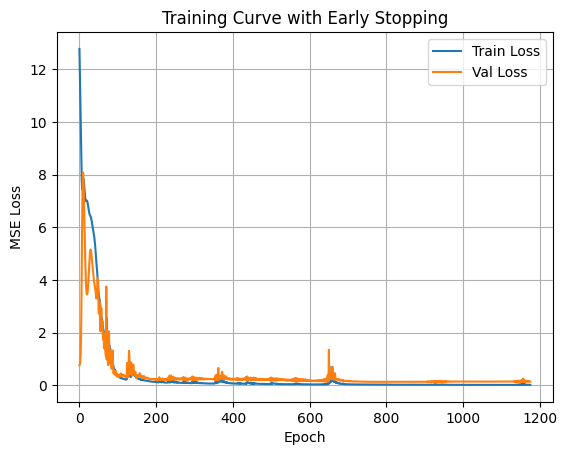

In [53]:
# Model setup
gru1_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru1_model.parameters(), lr=0.01)

# Early stopping parameters
patience = 250
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru1_model.train()
    optimizer.zero_grad()
    y_pred_train = gru1_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru1_model.eval()
    with torch.no_grad():
        y_pred_val = gru1_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = gru1_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    gru1_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Predict on validation set
gru1_model.eval()
with torch.no_grad():
    y_pred_scaled = gru1_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru1 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru1)
mae = mean_absolute_error(y_true, y_pred_gru1)
r2 = r2_score(y_true, y_pred_gru1)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.012 cm/s
MAE: 0.051 cm/s
R² Score: 0.820


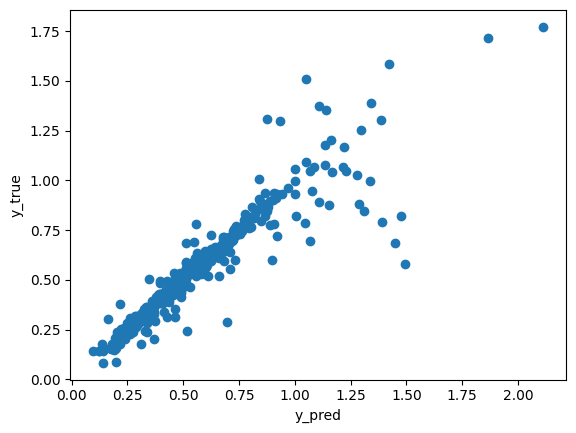

In [55]:
plt.figure()
plt.scatter(y_pred_gru1,y_true)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

Epoch 1/2000 - Train Loss: 11.5597 - Val Loss: 0.8202
Epoch 50/2000 - Train Loss: 4.0171 - Val Loss: 2.7684
Epoch 100/2000 - Train Loss: 0.7740 - Val Loss: 1.0137
Epoch 150/2000 - Train Loss: 0.1485 - Val Loss: 0.2730
Epoch 200/2000 - Train Loss: 0.0853 - Val Loss: 0.1819
Epoch 250/2000 - Train Loss: 0.2480 - Val Loss: 0.5081
Epoch 300/2000 - Train Loss: 0.0722 - Val Loss: 0.1362
Epoch 350/2000 - Train Loss: 0.0570 - Val Loss: 0.1152
Epoch 400/2000 - Train Loss: 0.0362 - Val Loss: 0.1119
Epoch 450/2000 - Train Loss: 0.0293 - Val Loss: 0.1063
Epoch 500/2000 - Train Loss: 0.0251 - Val Loss: 0.0938
Epoch 550/2000 - Train Loss: 0.0224 - Val Loss: 0.0831
Epoch 600/2000 - Train Loss: 0.0204 - Val Loss: 0.0821
Epoch 650/2000 - Train Loss: 0.0170 - Val Loss: 0.0737
Epoch 700/2000 - Train Loss: 0.0220 - Val Loss: 0.0704
Epoch 750/2000 - Train Loss: 0.0149 - Val Loss: 0.0728
Epoch 800/2000 - Train Loss: 0.0123 - Val Loss: 0.0688
Epoch 850/2000 - Train Loss: 0.0106 - Val Loss: 0.0669
Epoch 900/20

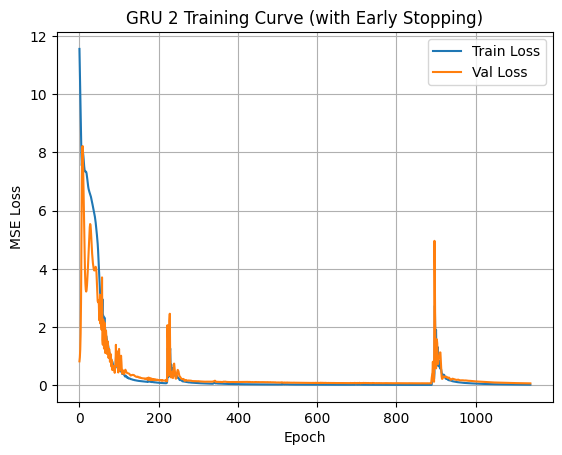

In [57]:
gru2_model = GRUModel(input_size=1, hidden_size=30, num_layers=2)
gru2_model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(gru2_model.parameters(), lr=0.008)
criterion = torch.nn.MSELoss()

# Early stopping setup
patience = 250
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru2_model.train()
    optimizer.zero_grad()
    pred_train = gru2_model(X_train_tensor)
    loss = criterion(pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru2_model.eval()
    with torch.no_grad():
        pred_val = gru2_model(X_val_tensor)
        val_loss = criterion(pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = gru2_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
if best_model_state is not None:
    gru2_model.load_state_dict(best_model_state)

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("GRU 2 Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

In [60]:
# Predict on validation set
gru2_model.eval()
with torch.no_grad():
    y_pred_scaled = gru2_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru2 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru2)
mae = mean_absolute_error(y_true, y_pred_gru2)
r2 = r2_score(y_true, y_pred_gru2)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.006 cm/s
MAE: 0.038 cm/s
R² Score: 0.917


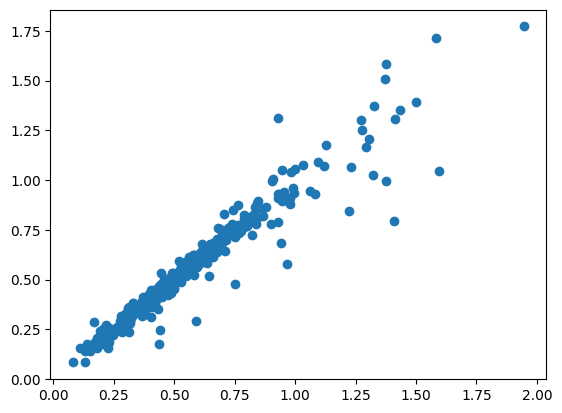

In [61]:
plt.figure()
plt.scatter(y_pred_gru2,y_true)
plt.show()

Epoch 1/5000 - Train Loss: 12.2696 - Val Loss: 0.7618
Epoch 100/5000 - Train Loss: 8.0924 - Val Loss: 4.1327
Epoch 200/5000 - Train Loss: 7.1986 - Val Loss: 4.4803
Epoch 300/5000 - Train Loss: 6.3818 - Val Loss: 3.7908
Epoch 400/5000 - Train Loss: 5.4701 - Val Loss: 4.5940
Epoch 500/5000 - Train Loss: 1.2533 - Val Loss: 1.4147
Epoch 600/5000 - Train Loss: 1.2297 - Val Loss: 1.8417
Epoch 700/5000 - Train Loss: 0.2700 - Val Loss: 0.5124
Epoch 800/5000 - Train Loss: 0.3050 - Val Loss: 0.4575
Epoch 900/5000 - Train Loss: 0.2183 - Val Loss: 0.3379
Epoch 1000/5000 - Train Loss: 0.3496 - Val Loss: 0.4547
Epoch 1100/5000 - Train Loss: 0.2307 - Val Loss: 0.3302
Epoch 1200/5000 - Train Loss: 0.1546 - Val Loss: 0.2720
Epoch 1300/5000 - Train Loss: 1.1839 - Val Loss: 2.1625
Epoch 1400/5000 - Train Loss: 0.2331 - Val Loss: 0.4102
Epoch 1500/5000 - Train Loss: 0.1542 - Val Loss: 0.3170
Epoch 1600/5000 - Train Loss: 0.1129 - Val Loss: 0.2734
Epoch 1700/5000 - Train Loss: 0.0605 - Val Loss: 0.2078
Epo

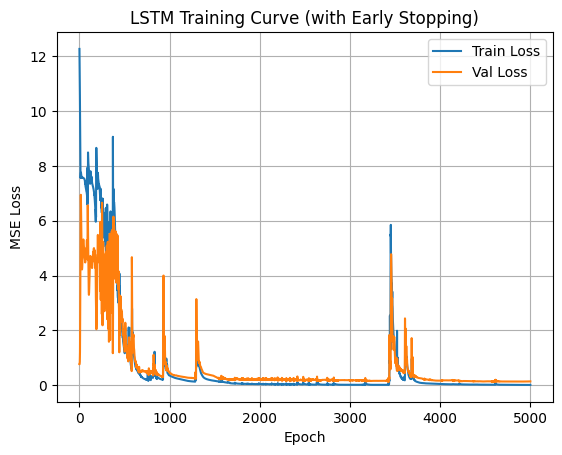

In [80]:
lstm_model = LSTMModel(input_size=1, hidden_size=25, num_layers=2)
lstm_model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.005)

# Early stopping setup
patience = 2000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 5000
train_losses, val_losses = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train = lstm_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    lstm_model.eval()
    with torch.no_grad():
        y_pred_val = lstm_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = lstm_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
if best_model_state is not None:
    lstm_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("LSTM Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


In [83]:
# Predict on validation set
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled = lstm_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_lstm = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_lstm)
mae = mean_absolute_error(y_true, y_pred_lstm)
r2 = r2_score(y_true, y_pred_lstm)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.012 cm/s
MAE: 0.050 cm/s
R² Score: 0.822


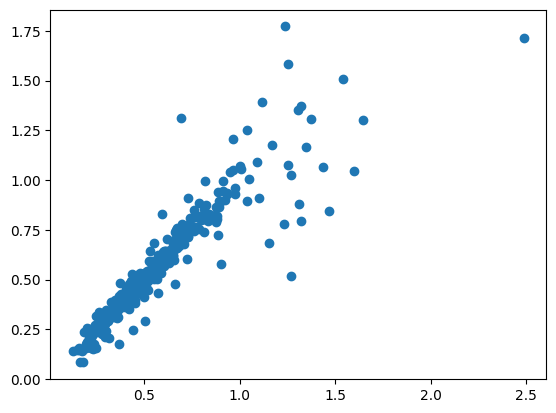

In [84]:
plt.figure()
plt.scatter(y_pred_lstm,y_true)
plt.show()

In [85]:
with torch.no_grad():  
    y_gru1_scaled = gru1_model(X_test_tensor)
    y_gru2_scaled = gru2_model(X_test_tensor)
    y_lstm_scaled = lstm_model(X_test_tensor)
    
y_gru1 = target_scaler.inverse_transform(y_gru1_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2 = target_scaler.inverse_transform(y_gru2_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm = target_scaler.inverse_transform(y_lstm_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()

y_pred = ((y_lstm+y_gru1+y_gru2)/3).flatten()
outcome_df = pd.DataFrame({"predictions model 1": y_gru1, "predictions model 2": y_gru2, "predictions model 3": y_lstm, "final prediction": y_pred})
outcome_df['Standard deviation'] = outcome_df[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df['Standard deviation %'] = outcome_df['Standard deviation'] / outcome_df['final prediction'] * 100
 
print(outcome_df.head(10))

   predictions model 1  predictions model 2  predictions model 3  \
0             0.777502             0.801610             0.742362   
1             0.931224             1.180936             1.257928   
2             0.365123             0.370021             0.353993   
3             0.570889             0.605447             0.606956   
4             0.274714             0.251222             0.271908   
5             0.976161             0.919977             0.733367   
6             0.768668             0.750927             0.766868   
7             0.569523             0.577871             0.605238   
8             0.296525             0.317670             0.257361   
9             0.352752             0.332559             0.298261   

   final prediction  Standard deviation  Standard deviation %  
0          0.773825            0.029795              3.850346  
1          1.123363            0.170792             15.203608  
2          0.363046            0.008213              2.2623

In [86]:
# Evaluation metrics (remove '''...''' if interested)
valid_bubbles_ai = len(outcome_df[outcome_df['Standard deviation %'] < 10])/len(outcome_df) * 100
valid_bubbles_boring_software = len(valid_velo_data(df)[0])/len(df) * 100

X_velo, y_velo = valid_velo_data(df)
X_velo_scaled = torch.tensor(feature_scaler.transform(X_velo)[...,np.newaxis], dtype=torch.float32)
X_velo_scaled = X_velo_scaled.to(device)
with torch.no_grad():  
        y_gru1_scaled_velo = gru1_model(X_velo_scaled)
        y_gru2_scaled_velo = gru2_model(X_velo_scaled)
        y_lstm_scaled_velo = lstm_model(X_velo_scaled)
y_gru1_velo = target_scaler.inverse_transform(y_gru1_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2_velo = target_scaler.inverse_transform(y_gru2_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm_velo = target_scaler.inverse_transform(y_lstm_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_pred_velo = ((y_lstm_velo+y_gru1_velo+y_gru2_velo)/3).flatten()
outcome_df_valid = pd.DataFrame({"predictions model 1": y_gru1_velo, "predictions model 2": y_gru2_velo, "predictions model 3": y_lstm_velo, "final prediction": y_pred_velo})
outcome_df_valid['Standard deviation'] = outcome_df_valid[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df_valid['Standard deviation %'] = outcome_df_valid['Standard deviation'] / outcome_df_valid['final prediction'] * 100
valid_test_results = outcome_df_valid[(outcome_df_valid["Standard deviation"]/outcome_df_valid["final prediction"]) <= 0.1]

filtered_outcome_df = outcome_df[outcome_df['Standard deviation %'] < 10]
average_percentage_std = filtered_outcome_df['Standard deviation %'].mean()

print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <10% from truth:  {len(valid_test_results) / (len(outcome_df_valid)) * 100:.4f} %")
print(f'Percentage AI found valid bubbles (uncertainty < 10%): {valid_bubbles_ai:.4f} % vs M2 analyzer: {valid_bubbles_boring_software:.4f} %, improvement: {((valid_bubbles_ai - valid_bubbles_boring_software)/valid_bubbles_boring_software)*100:.4f} %')
print(f'Model uncertainty (average uncertainty of valid bubbles): {average_percentage_std:.4f} % with {len(filtered_outcome_df) / len(outcome_df_valid) * 100} % of the labled samples')


Percentage found valid bubbles (uncertainty < 10%) with speed difference <10% from truth:  86.1210 %
Percentage AI found valid bubbles (uncertainty < 10%): 80.0948 % vs M2 analyzer: 35.9795 %, improvement: 122.6122 %
Model uncertainty (average uncertainty of valid bubbles): 4.2929 % with 20.047449584816132 % of the labled samples


In [88]:
torch.save(gru1_model.state_dict(), path_to_output+"/gru12-5_is1_ns20_nl2_lr0.01")
torch.save(gru2_model.state_dict(), path_to_output+"/gru12-5_is1_ns30_nl2_lr0.008")
torch.save(lstm_model.state_dict(), path_to_output+"/lstm12-5_is1_ns25_nl2_lr0.005")